# This notebook contains feature engineering steps: variable encoding, power transformations, binary datetime feature extraction, and NLP (tfidf vectorization). 

# Training and testing splits (contained in sparse matrices) are now ready for modeling (see last cell). 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\casti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dfpr = pd.read_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfpr.csv')

In [3]:
dfpr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23764 entries, 0 to 23763
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       23764 non-null  int64  
 1   date             23764 non-null  object 
 2   latitude         23764 non-null  float64
 3   longitude        23764 non-null  float64
 4   motive           23764 non-null  object 
 5   targtype1_txt    23764 non-null  object 
 6   weaptype1_txt    23764 non-null  object 
 7   attacktype1_txt  23764 non-null  object 
 8   kill_trans       23764 non-null  float64
 9   wound_trans      23764 non-null  float64
 10  fatalities_cat   23764 non-null  object 
 11  wound_cat        23764 non-null  object 
 12  success          23764 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 2.4+ MB


In [4]:
pd.set_option('display.max_colwidth',None)
dfpr.motive

0                                                                                                                            It was believed this attack was meant to intimidate UN inspectors and halt weapons inspections.
1                                                                                                                      It was believed that the attack was a protest to election results that occurred on December 15, 1997.
2                                                                                                                      It was believed that the attack was a protest to election results that occurred on December 15, 1997.
3                                                                                                                            This attack was meant to terrorize civilians and the government ahead of continued peace talks.
4                                                                     It was believed that this attack was one of a 

In [5]:
for idx, val in dfpr.motive.items():
    if re.search(r'\bbelieved\b', val):
        print(val)

It was believed this attack was meant to intimidate UN inspectors and halt weapons inspections.
It was believed that the attack was a protest to election results that occurred on December 15, 1997.
It was believed that the attack was a protest to election results that occurred on December 15, 1997.
It was believed that this attack was one of a series of retribution killings that occurred following the death of the attackers' leader, Billy Wright.
Authorities believed that this was part of a bigger plan aimed at causing insecurity and threatening the Yugoslav state border with Albania along the entire border line.
Israeli political and security elements believed that the perpetrators wanted to prevent progress in the political negotiations, specifically he meeting between Defense Minister Yitzhaq Mordekhay and Abu-Mazin (Mahmud 'Abbas), scheduled for that day.
The attackers believed that the victims were providing support to Revolutionary Armed Forces of Colombia (FARC)
The government b

In [6]:
for idx, val in dfpr.motive.items():
    if re.search(r'\bbelieved\b', val):
        dfpr.loc[idx, 'motive'] = re.sub(r'\bbelieved\b', '', val)
    if re.search(r'[0-9]', val):
        dfpr.loc[idx, 'motive'] = re.sub(r'[0-9]', '', val)
print(dfpr.motive.head())

0                                                           It was  this attack was meant to intimidate UN inspectors and halt weapons inspections.
1                                                   It was believed that the attack was a protest to election results that occurred on December , .
2                                                   It was believed that the attack was a protest to election results that occurred on December , .
3                                                   This attack was meant to terrorize civilians and the government ahead of continued peace talks.
4    It was  that this attack was one of a series of retribution killings that occurred following the death of the attackers' leader, Billy Wright.
Name: motive, dtype: object


In [7]:
dfpr = dfpr.drop(columns = ['kill_trans','wound_trans'])

In [8]:
dfenc1 = pd.get_dummies(dfpr.targtype1_txt, prefix='targ')
dfenc2 = pd.get_dummies(dfpr.attacktype1_txt, prefix='att')
dfenc3 = pd.get_dummies(dfpr.weaptype1_txt, prefix='weap')
dfenc = pd.concat([dfenc1, dfenc2, dfenc3], axis=1)

fatal_order = [['0', '1-5', '5-14', '15+']]
wound_order = [['0', '1-5', '5-14', '15-29', '30+']]

fat_enc = OrdinalEncoder(categories=fatal_order)
dfenc['fatal_enc'] = fat_enc.fit_transform(dfpr[['fatalities_cat']])
wound_enc = OrdinalEncoder(categories=wound_order)
dfenc['wound_enc'] = wound_enc.fit_transform(dfpr[['wound_cat']])

In [9]:
dfenc.wound_enc.value_counts()

wound_enc
0.0    15355
1.0     5309
2.0     1703
3.0      755
4.0      642
Name: count, dtype: int64

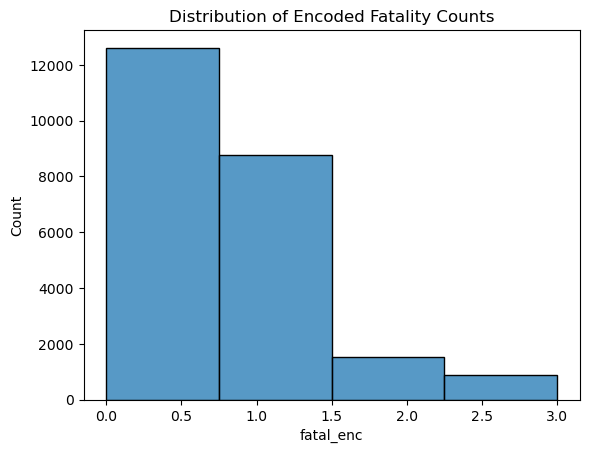

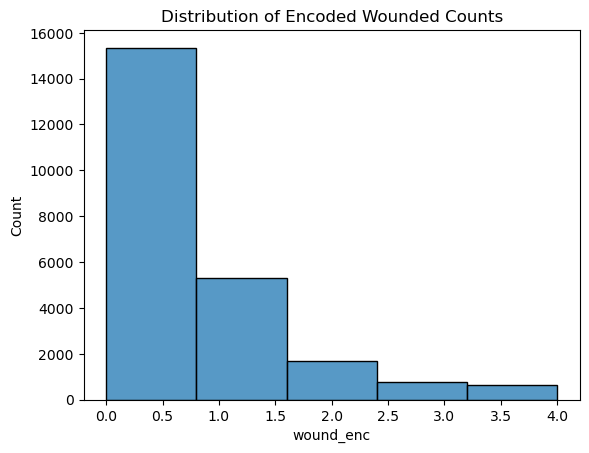

In [10]:
sns.histplot(dfenc.fatal_enc, bins=4)
plt.title('Distribution of Encoded Fatality Counts')
plt.show();
sns.histplot(dfenc.wound_enc, bins=5)
plt.title('Distribution of Encoded Wounded Counts')
plt.show();

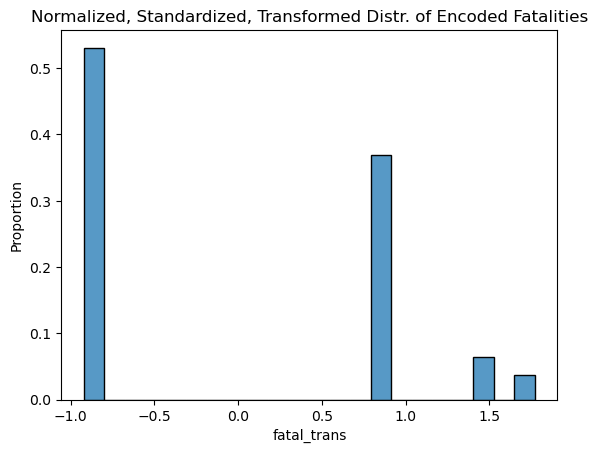

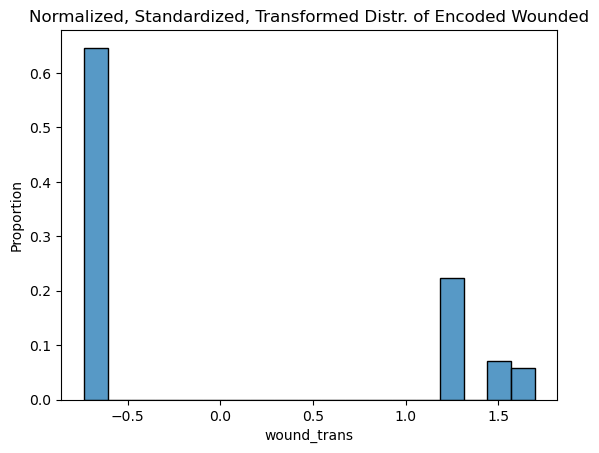

In [11]:
pt = PowerTransformer()
pt.fit(np.array(dfenc.fatal_enc).reshape(-1,1))
dfenc['fatal_trans'] = pt.transform(np.array(dfenc.fatal_enc).reshape(-1,1))
sns.histplot(dfenc.fatal_trans, stat='proportion')
plt.title('Normalized, Standardized, Transformed Distr. of Encoded Fatalities')
plt.show();

pt = PowerTransformer()
pt.fit(np.array(dfenc.wound_enc).reshape(-1,1))
dfenc['wound_trans'] = pt.transform(np.array(dfenc.wound_enc).reshape(-1,1))
plt.title('Normalized, Standardized, Transformed Distr. of Encoded Wounded')
sns.histplot(dfenc.wound_trans, stat='proportion')
plt.show();

In [12]:
dfpr['date'] = pd.to_datetime(dfpr['date'])
dfpr['day_of_week'] = dfpr['date'].dt.dayofweek
dfpr['is_weekend'] = dfpr['day_of_week'].isin([5, 6]).astype(int)

# For now, I will use the is_weekend date feature, all encoded variables from above, and the motive as features in the model.
# Can potentially incorporate geographical info down the line if this goes well.

In [16]:
dfpr.shape

(23764, 13)

In [18]:
dfall = pd.concat([dfpr, dfenc], axis=1).drop(columns = ['Unnamed: 0', 'date','day_of_week','latitude','longitude','targtype1_txt','weaptype1_txt','attacktype1_txt','fatalities_cat','wound_cat','fatal_trans','wound_trans'])

X = dfall.drop(columns='success')
y = dfall[['success']]

y.shape

(23764, 1)

In [19]:
dfall.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfall.csv')
dfpr.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\dfpr.csv')

X.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\X.csv')
y.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\y.csv')


# Split into training and testing sets BEFORE applying tokenization, lemmatization, or TFIDF vectorization - this prevents data leakage.

In [30]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=123, test_size=0.25, stratify=y)

In [49]:
for val in [X_tr, X_te, y_tr, y_te]:
    print(val.shape)

(17823, 39)
(5941, 39)
(17823, 1)
(5941, 1)


In [50]:
X_tr['tok'] = X_tr['motive'].apply(word_tokenize)

In [51]:
wnl = WordNetLemmatizer()
def lem_tokens(tokens) :
    lem = [wnl.lemmatize(token) for token in tokens]
    return ' '.join(lem)
    

X_tr['lem'] = X_tr.tok.apply(lem_tokens)
X_tr['lem']

15391                                                    The specific motive is unknown ; however , source posited that the attack wa carried out in retaliation for the Saudi government 's execution of Shi'ite cleric Sheikh Nimr al-Nimr and others .
2828                                                                                                                                                                                                                              Protesting Republic Day
1240                                                                                Although the specific motive for the attack wa unknown , source note that the Forces for the Defense of Democracy ( FDD ) had carried out many attack in the region .
1542                      Although the specific motive wa unknown , source note that at least two other suspected anthrax attack had occurred in Kenya at the same time , and they were possibly related to the September , attack on the United States .


In [52]:
tv = TfidfVectorizer(ngram_range=(2,3), stop_words='english')

In [53]:
tv.fit(X_tr['lem'])
motive_vec = tv.transform(X_tr['lem'])

In [54]:
motive_vec.shape

(17823, 162890)

In [36]:
# X_tr_vec = pd.concat([X_tr, pd.DataFrame(motive_vec.toarray(), columns = tv.get_feature_names_out())], axis=1)

MemoryError: Unable to allocate 27.0 GiB for an array with shape (22246, 162890) and data type float64

# Memory error due to high dimensionality. Proceeding with sparse matrices instead of dfs.

In [55]:
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

X_tr_num = X_tr.drop(columns = ['motive','tok','lem']).astype(int)

X_tr_sparse = csr_matrix(X_tr_num.values)

# Concatenate sparse matrix (motive_vec) horizontally with DataFrame (X_tr)
X_tr_vec = hstack([X_tr_sparse, motive_vec])

In [56]:
X_te['tok'] = X_te['motive'].apply(word_tokenize)
wnl = WordNetLemmatizer()
def lem_tokens(tokens) :
    lem = [wnl.lemmatize(token) for token in tokens]
    return ' '.join(lem)
    

X_te['lem'] = X_te.tok.apply(lem_tokens)

print(X_te['lem'])

motive_vec = tv.transform(X_te['lem'])

X_te_num = X_te.drop(columns = ['motive','tok','lem']).astype(int)

X_te_sparse = csr_matrix(X_te_num.values)

X_te_vec = hstack([X_te_sparse, motive_vec])

1903                                                       Specific motive is unknown ; however , authority interpret the explosion a a message from separatist to the French government to expedite granting greater autonomy to Corsica .
16782                                       The specific motive is unknown ; however , source posited that the attack wa part of a larger trend of sectarian violence between Afghanistan 's majority Sunni and minority Shiite community .
4582                                                                                                                                                                                          The specific motive for the attack is unknown
1324                                             Although the specific motive for this attack wa unknown , source noted that the Taliban blamed member of the opposition and claimed they were trying to destroy the way of life in Kabul .
5413                                                    

In [57]:
print(X_tr_vec.shape)
print(X_te_vec.shape)
print(y_tr.shape)
print(y_te.shape)

(17823, 162926)
(5941, 162926)
(17823, 1)
(5941, 1)


# Training and testing sets ready for modeling. I will test Logistic Regression, Random Forest, Naive Bayes, and potentially Convoluted or Recurrent Neural Networks in the next phase. 

In [ ]:
sp.sparse.save_npz(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\X_tr_vec.npz', X_tr_vec)

In [ ]:
sp.sparse.save_npz(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\X_te_vec.npz', X_te_vec)

In [ ]:
y_tr.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\y_tr_final.csv')
y_te.to_csv(r'C:\Users\casti\OneDrive\Documents\A Springboard\Capstone 2 - Global Terrorism\data\interim\y_te.csv')
